In [5]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [6]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:39<00:00, 31.7MB/s]
100% 1.14G/1.14G [00:39<00:00, 31.1MB/s]


In [7]:
import zipfile

zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [10]:
#Define standard parameter values
batch_size = 16
img_height = 500
img_width = 500

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

image_gen = ImageDataGenerator(
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                              
                               )  

test_data_gen = ImageDataGenerator(rescale = 1./255)



train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )

test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [12]:
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [13]:
# let's build the CNN model

cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 249, 249, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 123, 123, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 60, 60, 32)       0

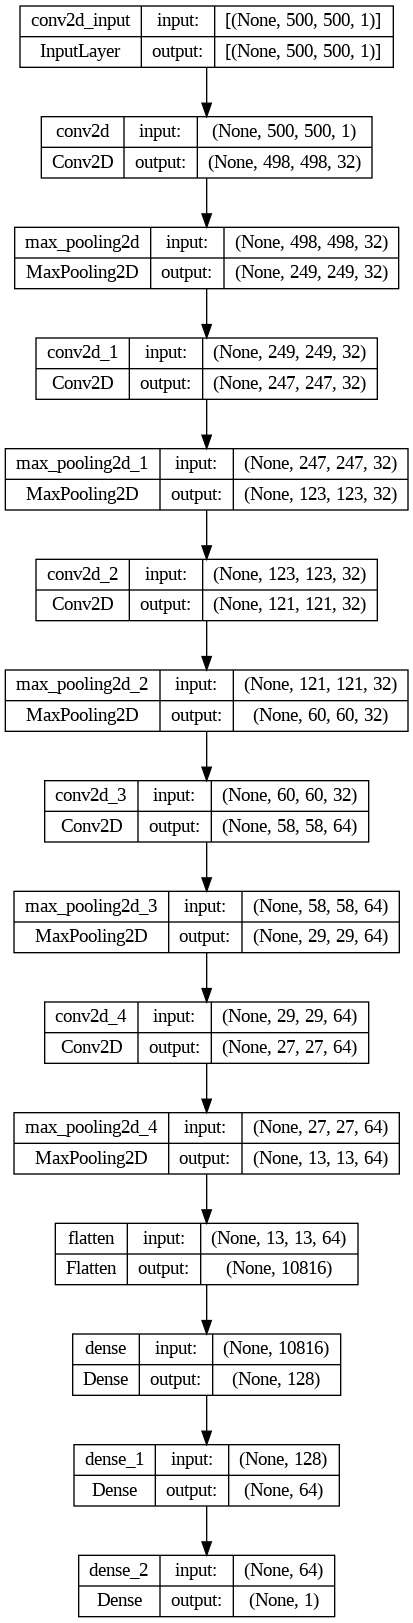

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [16]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

callbacks_list = [ early, learning_rate_reduction]

In [17]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.classes), y=train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
cnn.fit(train,epochs=25, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/25
101/262 [==========>...................] - ETA: 17:13 - loss: 0.6650 - accuracy: 0.5198

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
fp = "/content/drive/My Drive/cnn_pneu_vamp_model.h5"
#cnn.save(fp)

In [18]:
cnn = load_model(fp)

In [19]:
cnn.predict_segmentation()

AttributeError: ignored

In [20]:
pd.DataFrame(cnn.history.history).plot()

AttributeError: ignored

In [21]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 51s 1s/step - loss: 0.3733 - accuracy: 0.8862
The testing accuracy is : 88.62179517745972 %


In [22]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 50s 1s/step


In [23]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

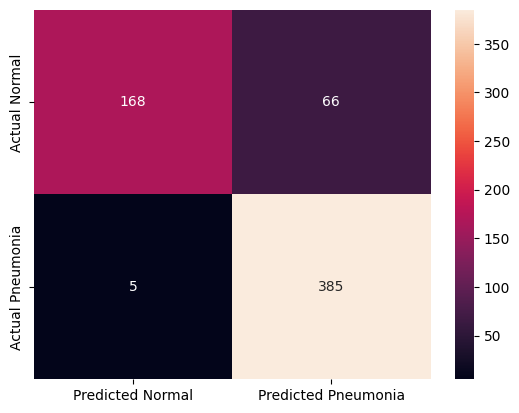

In [24]:
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [25]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.97      0.72      0.83       234
   PNEUMONIA       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



In [26]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 500, 500, 1)
(624,)


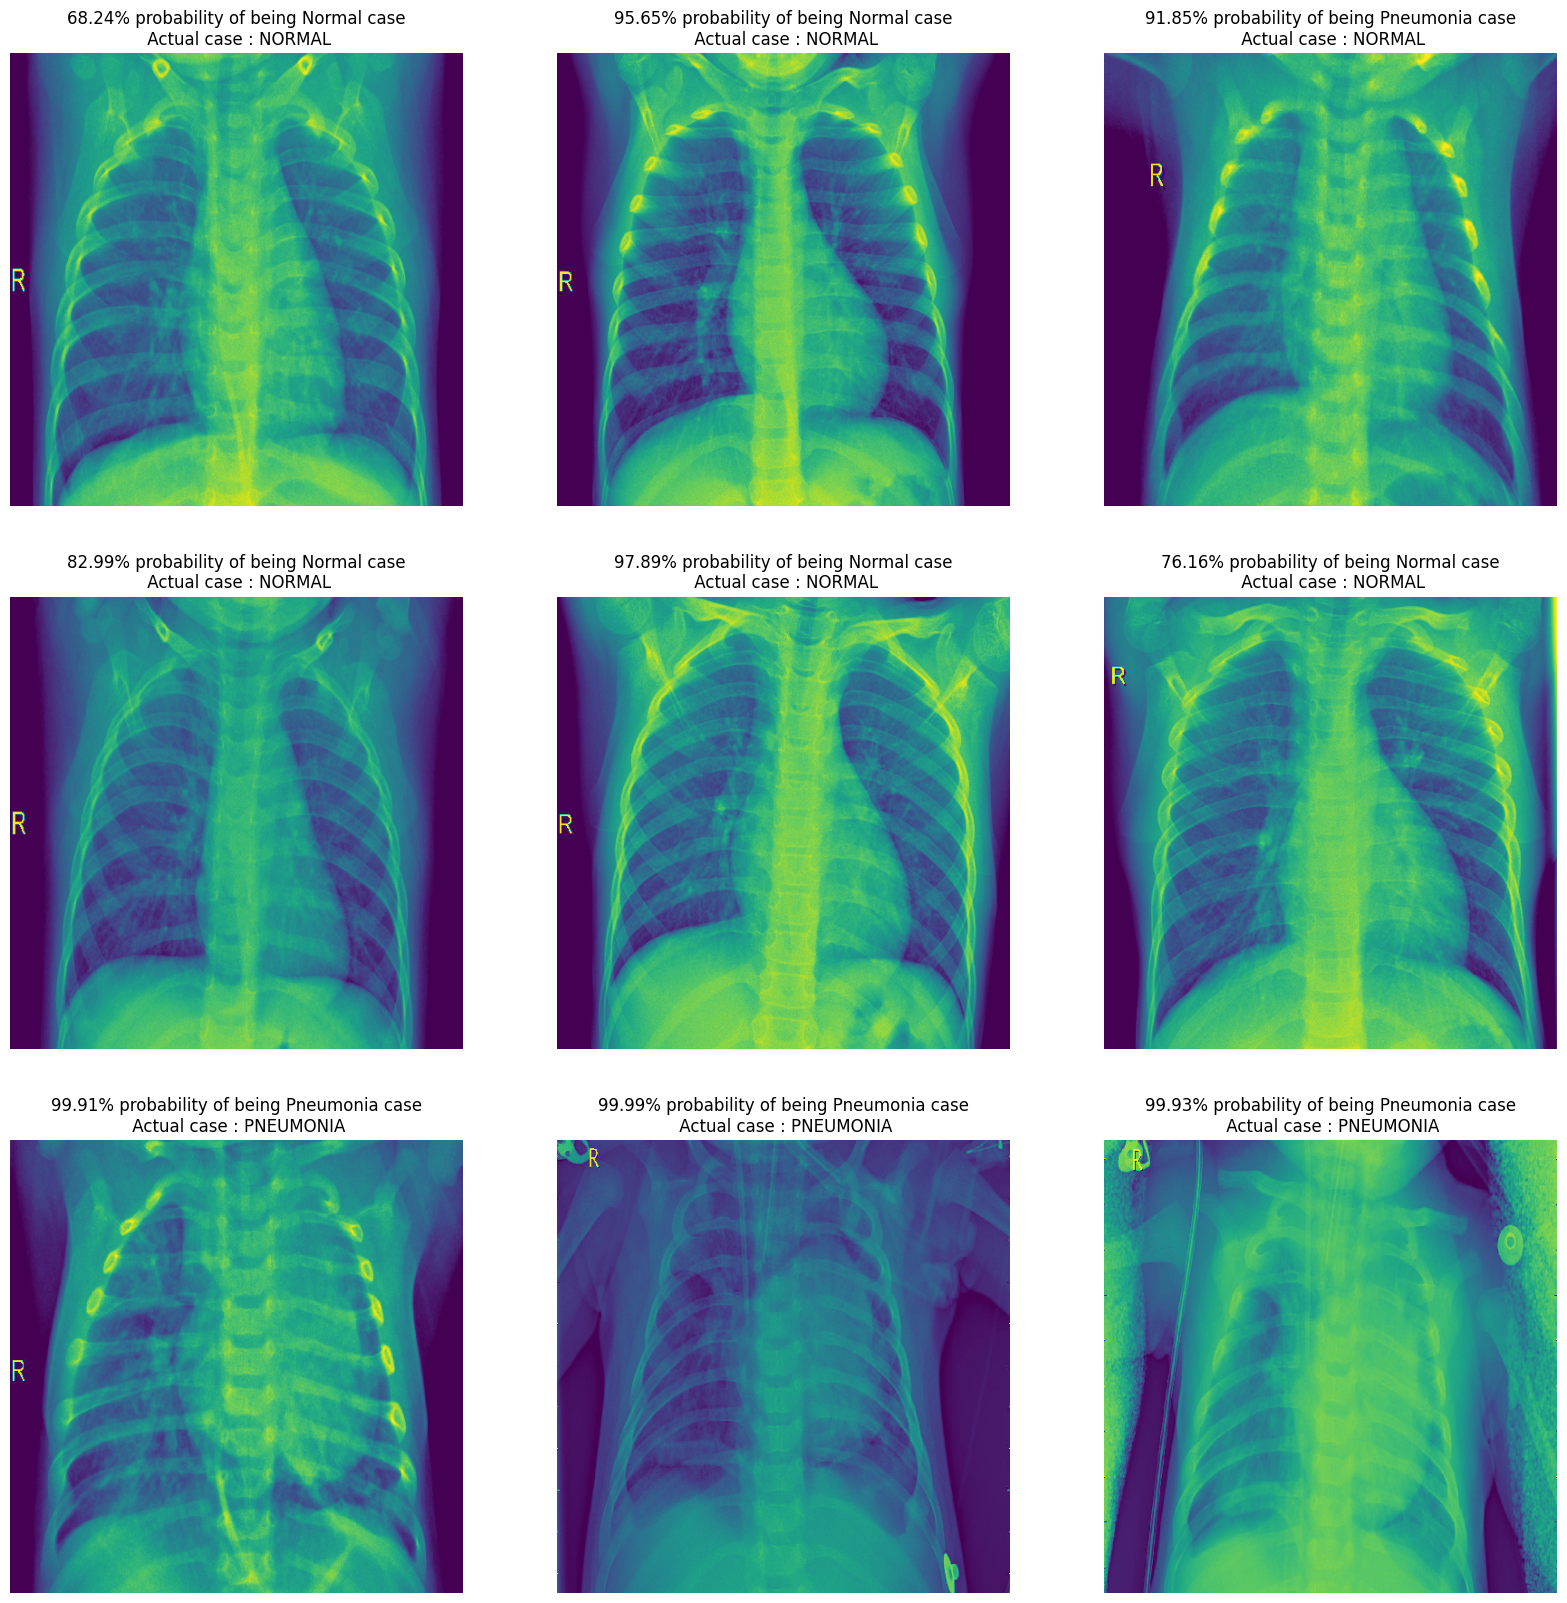

In [27]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
      
      

  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [28]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=y ) )\nfig.show()'

In [29]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure( go.Scatter(y=predictions[:,0] ) )\nfig.show()'

1/1 [==============================] - 0s 89ms/step


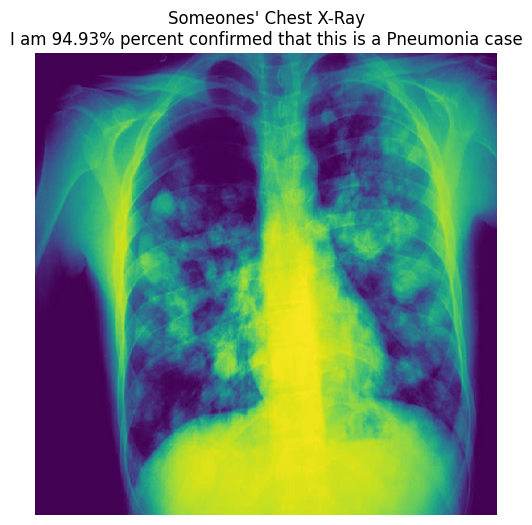

In [34]:
# Testing with my own Chest X-Ray
#hardik_path = '/content/drive/My Drive/NormalXrayImage.jpg'
hardik_path = '/content/drive/My Drive/pneumonia.jpg'
from tensorflow.keras.preprocessing import image

hardik_img = image.load_img(hardik_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_hardik_img = image.img_to_array(hardik_img)
pp_hardik_img = pp_hardik_img/255
pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

#predict
hardik_preds= cnn.predict(pp_hardik_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if hardik_preds>= 0.5: 
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))
    
else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))
    

plt.title("Someones' Chest X-Ray\n"+out)  
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

In [35]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 74.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.2 MB/s eta 0:00:00


In [36]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!wget https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py

--2023-05-25 07:57:03--  https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1607 (1.6K) [text/plain]
Saving to: ‘webapp.py’

webapp.py           100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-05-25 07:57:03 (23.7 MB/s) - ‘webapp.py’ saved [1607/1607]



In [38]:
%%writefile webapp.py
import streamlit as st
import numpy as np
from PIL import Image 
from tensorflow.keras.models import load_model
import tensorflow as tf
 
from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image 

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)

def loading_model():
  fp = "cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()
st.write("""
# X-Ray Classification (Pneumonia/Normal)
""")



  


temp = st.file_uploader("Upload X-Ray Image")

buffer = temp
temp_file = NamedTemporaryFile(delete=False)
if buffer:
    temp_file.write(buffer.getvalue())
    st.write(image.load_img(temp_file.name))


if buffer is None:
  st.text("Oops! that doesn't look like an image. Try again.")

else:

 

  hardik_img = image.load_img(temp_file.name, target_size=(500, 500),color_mode='grayscale')

  # Preprocessing the image
  pp_hardik_img = image.img_to_array(hardik_img)
  pp_hardik_img = pp_hardik_img/255
  pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

  #predict
  hardik_preds= cnn.predict(pp_hardik_img)
  if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))
  
  else: 
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))

  st.success(out)
  
  image = Image.open(temp)
  st.image(image,use_column_width=True)
          
        

Overwriting webapp.py


In [ ]:
!streamlit run /content/webapp.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.91.253.141:8501



In [40]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2023-05-25 08:02:11--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  13.9MB/s    in 1.0s    

2023-05-25 08:02:12 (13.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [41]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [42]:
get_ipython().system_raw('./ngrok http 8501 &')

In [44]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.9/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.9/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.9/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.9/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)
